### LSTM-based Recurrent Neural Network (RNN) to predict SBIN (State Bank of India) stock price

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty50-stock-market-data/TCS.csv
/kaggle/input/nifty50-stock-market-data/MARUTI.csv
/kaggle/input/nifty50-stock-market-data/ONGC.csv
/kaggle/input/nifty50-stock-market-data/TITAN.csv
/kaggle/input/nifty50-stock-market-data/KOTAKBANK.csv
/kaggle/input/nifty50-stock-market-data/BAJFINANCE.csv
/kaggle/input/nifty50-stock-market-data/ASIANPAINT.csv
/kaggle/input/nifty50-stock-market-data/IOC.csv
/kaggle/input/nifty50-stock-market-data/INFRATEL.csv
/kaggle/input/nifty50-stock-market-data/TATASTEEL.csv
/kaggle/input/nifty50-stock-market-data/TATAMOTORS.csv
/kaggle/input/nifty50-stock-market-data/BHARTIARTL.csv
/kaggle/input/nifty50-stock-market-data/BPCL.csv
/kaggle/input/nifty50-stock-market-data/HDFCBANK.csv
/kaggle/input/nifty50-stock-market-data/BRITANNIA.csv
/kaggle/input/nifty50-stock-market-data/POWERGRID.csv
/kaggle/input/nifty50-stock-market-data/WIPRO.csv
/kaggle/input/nifty50-stock-market-data/DRREDDY.csv
/kaggle/input/nifty50-stock-market-data/ITC.csv
/kaggle/input

In [2]:
### Importing Required Libraries ###

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

**Reading SBIN data from NIFTY 50 dataset**

In [3]:
#read the file
df = pd.read_csv("../input/nifty50-stock-market-data/SBIN.csv")

#print the head
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN


Setting Date as Index. We will use **Close** Price for prediction

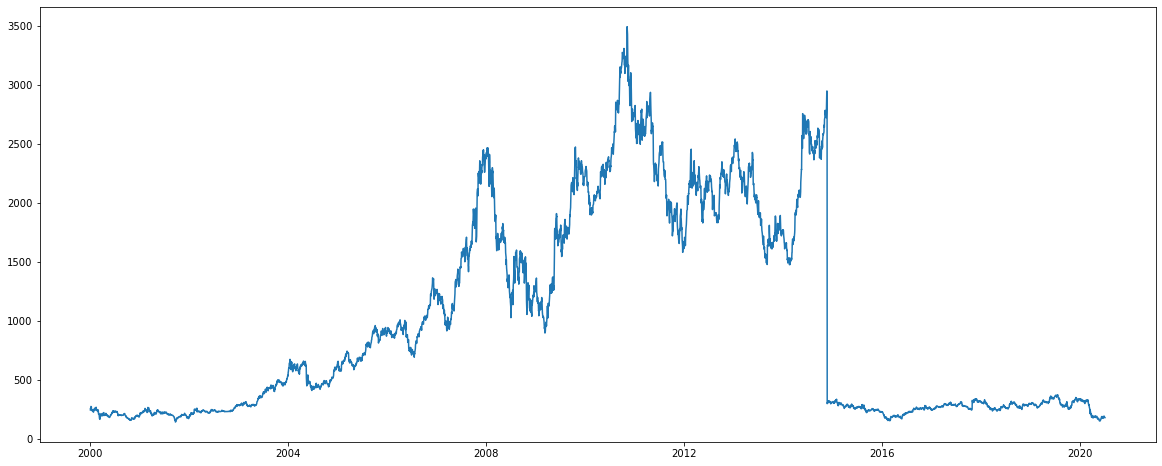

In [4]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(20,8))
plt.plot(df['Close'], label='Historical Close Price')

Selecting Close Price as feature and removing other columns from the data

In [5]:
features = ["Date", "Close"]
all_data = df[features]

In [6]:
#setting index
all_data.index = all_data.Date
all_data.drop('Date', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
all_data.head()

,Close
Date,
2000-01-03,243.65
2000-01-04,259.10
2000-01-05,248.45
2000-01-06,261.00
2000-01-07,273.30


In [8]:
all_data.shape

(5097, 1)

In [9]:
#creating training and validation sets
dataset = all_data.values

train = dataset[2000:4500,:]
valid = dataset[4500:,:]

### Feature Scaling

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

### Creating Sliding Window of 90 days

This data structure is needed to cover 90-days close price stamps, based on which RNN will predict the 91st day's close price. 

In [11]:
x_train, y_train = [], []
for i in range(90,len(train)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

#### Data Reshaping 

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Model Building

Initializing the LSTM model and 2nd, 3rd and 4th LSTM layer each with a Dropout Layer. The layers contain 50 neurons and with a Dropout rate of 20%, twenty percent of 50 neurons will be ignored randomly during each iteration

Finally, an output layer is added with 1 as an output dimension (as we are predicting the close price)

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(rate = 0.2))

model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(1))

Compiling the model with **Stochastic Gradient Descent** algorithm 

Using Mean Squared Error as Loss Function

In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
38/38 [==============================] - 10s 258ms/step - loss: 0.0123
Epoch 2/100
38/38 [==============================] - 10s 265ms/step - loss: 0.0019
Epoch 3/100
38/38 [==============================] - 9s 247ms/step - loss: 0.0016
Epoch 4/100
38/38 [==============================] - 11s 302ms/step - loss: 0.0014
Epoch 5/100
38/38 [==============================] - 9s 240ms/step - loss: 0.0013
Epoch 6/100
38/38 [==============================] - 9s 238ms/step - loss: 0.0013
Epoch 7/100
38/38 [==============================] - 9s 237ms/step - loss: 0.0013
Epoch 8/100
38/38 [==============================] - 10s 254ms/step - loss: 0.0013
Epoch 9/100
38/38 [==============================] - 10s 250ms/step - loss: 0.0012
Epoch 10/100
38/38 [==============================] - 9s 243ms/step - loss: 0.0012
Epoch 11/100
38/38 [==============================] - 9s 246ms/step - loss: 0.0012
Epoch 12/100
38/38 [==============================] - 9s 242ms/step - loss: 0.0011
Epoch 13

Epoch 96/100
38/38 [==============================] - 8s 208ms/step - loss: 4.5473e-04
Epoch 97/100
38/38 [==============================] - 8s 207ms/step - loss: 4.7663e-04
Epoch 98/100
38/38 [==============================] - 8s 204ms/step - loss: 4.5532e-04
Epoch 99/100
38/38 [==============================] - 8s 201ms/step - loss: 4.2455e-04
Epoch 100/100
38/38 [==============================] - 8s 207ms/step - loss: 4.6354e-04


### Preparing the Test data for prediction

In [25]:
#predicting test data values, using past 90 from the train data
inputs = all_data[len(all_data) - len(valid)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [26]:
inputs.shape

(687, 1)

In [27]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [28]:
X_test

array([[0.03883829, 0.03850978, 0.03773331, ..., 0.05011199, 0.04929073,
        0.05275496],
       [0.03850978, 0.03773331, 0.03840526, ..., 0.04929073, 0.05275496,
        0.05627893],
       [0.03773331, 0.03840526, 0.03794236, ..., 0.05275496, 0.05627893,
        0.05127669],
       ...,
       [0.05462147, 0.05338211, 0.05554726, ..., 0.0152307 , 0.01288637,
        0.01308048],
       [0.05338211, 0.05554726, 0.0531432 , ..., 0.01288637, 0.01308048,
        0.01288637],
       [0.05554726, 0.0531432 , 0.05159026, ..., 0.01308048, 0.01288637,
        0.01128864]])

In [29]:
X_test.shape

(597, 90)

In [30]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

### Calculating the RMSE to evaluate the model performance

In [35]:
rmse=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rmse

Close          10.783552
Predictions     0.000000
dtype: float64

### Plotting the output

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


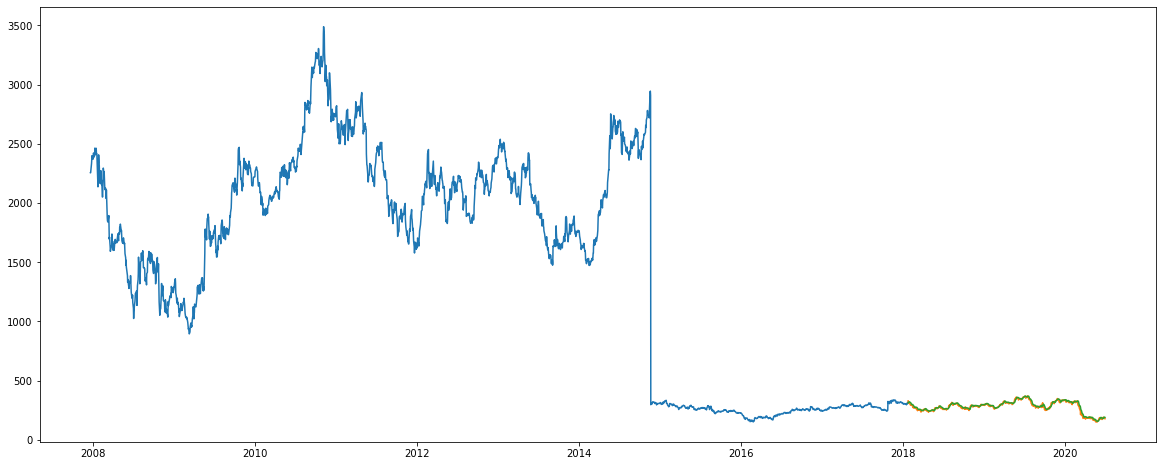

In [36]:
#for plotting
train = all_data[2000:4500]
valid = all_data[4500:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])